<a href="https://colab.research.google.com/github/Vishrutha1909/photo-restoration-lora/blob/vishrutha/photo_restoration_lora_notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipeline, DDPMScheduler

DEVICE = "cuda"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float32
).to(DEVICE)

pipe.scheduler = DDPMScheduler.from_pretrained(
    "runwayml/stable-diffusion-inpainting", subfolder="scheduler"
)

pipe.safety_checker = None
pipe.requires_safety_checker = False

pipe.enable_attention_slicing()
pipe.enable_vae_slicing()

pipe.vae.eval()
pipe.text_encoder.eval()

print("pipe recreated successfully")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

text_encoder/pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

safety_checker/pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
`torch_dtype` is deprecated! Use `dtype` instead!
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


pipe recreated successfully


In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["to_q","to_k","to_v","to_out.0"],
    lora_dropout=0.05,
    bias="none"
)

pipe.unet = get_peft_model(pipe.unet, lora_config)
pipe.unet.print_trainable_parameters()

print("Fresh LoRA attached")


trainable params: 3,188,736 || all params: 862,724,100 || trainable%: 0.3696
Fresh LoRA attached


In [ ]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

BASE_TRAIN_PATH = "/content/drive/MyDrive/photo-restoration-lora-vishrutha/data/train"

CLEAN_DIR   = os.path.join(BASE_TRAIN_PATH, "clean")
DAMAGED_DIR = os.path.join(BASE_TRAIN_PATH, "damaged")
MASK_DIR    = os.path.join(BASE_TRAIN_PATH, "mask")

class RestorationDataset(Dataset):
    def __init__(self):
        clean_files   = set(os.listdir(CLEAN_DIR))
        damaged_files = set(os.listdir(DAMAGED_DIR))
        mask_files    = set(os.listdir(MASK_DIR))

        self.files = sorted(clean_files & damaged_files & mask_files)
        print("Total aligned samples:", len(self.files))

        self.img_tf = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
        ])
        self.mask_tf = transforms.Compose([
            transforms.Resize((512,512)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]

        clean   = Image.open(os.path.join(CLEAN_DIR, fname)).convert("RGB")
        damaged = Image.open(os.path.join(DAMAGED_DIR, fname)).convert("RGB")
        mask    = Image.open(os.path.join(MASK_DIR, fname)).convert("L")

        return {
            "clean": self.img_tf(clean),
            "damaged": self.img_tf(damaged),
            "mask": self.mask_tf(mask),
        }

dataset = RestorationDataset()

loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

print("DataLoader ready | Batches:", len(loader))


Total aligned samples: 109
DataLoader ready | Batches: 109


In [ ]:
import torch
from diffusers import StableDiffusionInpaintPipeline, DDPMScheduler

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float32
).to(DEVICE)

pipe.scheduler = DDPMScheduler.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    subfolder="scheduler"
)

pipe.safety_checker = None
pipe.requires_safety_checker = False
pipe.enable_attention_slicing()
pipe.enable_vae_slicing()

pipe.vae.eval()
pipe.text_encoder.eval()

print("Clean FP32 base model ready")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


Clean FP32 base model ready


In [ ]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["to_q","to_k","to_v","to_out.0"],
    lora_dropout=0.05,
    bias="none"
)

pipe.unet = get_peft_model(pipe.unet, lora_config)
pipe.unet.print_trainable_parameters()

print("Fresh LoRA attached correctly")


trainable params: 3,188,736 || all params: 862,724,100 || trainable%: 0.3696
Fresh LoRA attached correctly


In [ ]:
batch = next(iter(loader))

print("Clean:", batch["clean"].shape)
print("Damaged:", batch["damaged"].shape)
print("Mask:", batch["mask"].shape)


Clean: torch.Size([1, 3, 512, 512])
Damaged: torch.Size([1, 3, 512, 512])
Mask: torch.Size([1, 1, 512, 512])


In [ ]:
from torch.optim import AdamW
import torch.nn.functional as F
from tqdm import tqdm
import torch

pipe.unet.train()
pipe.unet.float()

LR = 1e-5
EPOCHS = 5

optimizer = AdamW(pipe.unet.parameters(), lr=LR)

for epoch in range(EPOCHS):

    total_loss = 0.0
    valid_steps = 0

    for batch in tqdm(loader):

        clean   = batch["clean"].to(DEVICE)
        damaged = batch["damaged"].to(DEVICE)
        mask    = torch.clamp(batch["mask"].to(DEVICE), 0, 1)

        # ----- LATENT ENCODING -----
        with torch.no_grad():
            clean_latents   = pipe.vae.encode(clean).latent_dist.sample() * 0.18215
            damaged_latents = pipe.vae.encode(damaged).latent_dist.sample() * 0.18215
            mask_latent = torch.nn.functional.interpolate(
                mask, size=clean_latents.shape[-2:], mode="nearest"
            )

        # ----- NOISE -----
        noise = torch.randn_like(clean_latents)

        timesteps = torch.randint(
            0,
            pipe.scheduler.config.num_train_timesteps,
            (clean_latents.shape[0],),
            device=DEVICE
        ).long()

        noisy_latents = pipe.scheduler.add_noise(
            clean_latents, noise, timesteps
        )

        latent_model_input = torch.cat(
            [noisy_latents, damaged_latents, mask_latent], dim=1
        )

        # ----- TEXT -----
        text_ids = pipe.tokenizer(
            [""] * clean_latents.shape[0],
            return_tensors="pt"
        ).input_ids.to(DEVICE)

        with torch.no_grad():
            text_embeds = pipe.text_encoder(text_ids)[0]

        # ----- UNET -----
        model_pred = pipe.unet(
            latent_model_input,
            timesteps,
            encoder_hidden_states=text_embeds
        ).sample

        # ----- LOSS -----
        weight = mask_latent * 2.0 + 0.1
        loss = F.mse_loss(model_pred * weight, noise * weight)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(pipe.unet.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()
        valid_steps += 1

    avg = total_loss / valid_steps
    print(f"Epoch {epoch+1} DONE | Avg Loss: {avg:.6f}")


100%|██████████| 109/109 [06:55<00:00,  3.81s/it]


Epoch 1 DONE | Avg Loss: 0.295731


100%|██████████| 109/109 [02:10<00:00,  1.20s/it]


Epoch 2 DONE | Avg Loss: 0.200123


100%|██████████| 109/109 [02:13<00:00,  1.22s/it]


Epoch 3 DONE | Avg Loss: 0.268489


100%|██████████| 109/109 [02:14<00:00,  1.24s/it]


Epoch 4 DONE | Avg Loss: 0.234863


100%|██████████| 109/109 [02:14<00:00,  1.24s/it]

Epoch 5 DONE | Avg Loss: 0.211634


In [ ]:
SAVE_PATH = "/content/drive/MyDrive/photo-restoration-lora-vishrutha/lora_FINAL_TRAINED"

pipe.unet.save_pretrained(SAVE_PATH)
print("LoRA saved at:", SAVE_PATH)



LoRA saved at: /content/drive/MyDrive/photo-restoration-lora-vishrutha/lora_FINAL_TRAINED


In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch

DEVICE = "cuda"

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting",
    torch_dtype=torch.float16 if DEVICE == "cuda" else torch.float32
).to(DEVICE)

pipe.safety_checker = None
pipe.requires_safety_checker = False

pipe.load_lora_weights(
    "/content/drive/MyDrive/photo-restoration-lora-vishrutha/lora_FINAL_TRAINED"
)

pipe.enable_attention_slicing()

print("Trained LoRA loaded for testing")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--runwayml--stable-diffusion-inpainting/snapshots/8a4288a76071f7280aedbdb3253bdb9e9d5d84bb/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
No LoRA keys associated to UNet2DConditionModel found with the pre

Trained LoRA loaded for testing


Testing on: 107.jpg


  0%|          | 0/51 [00:00<?, ?it/s]

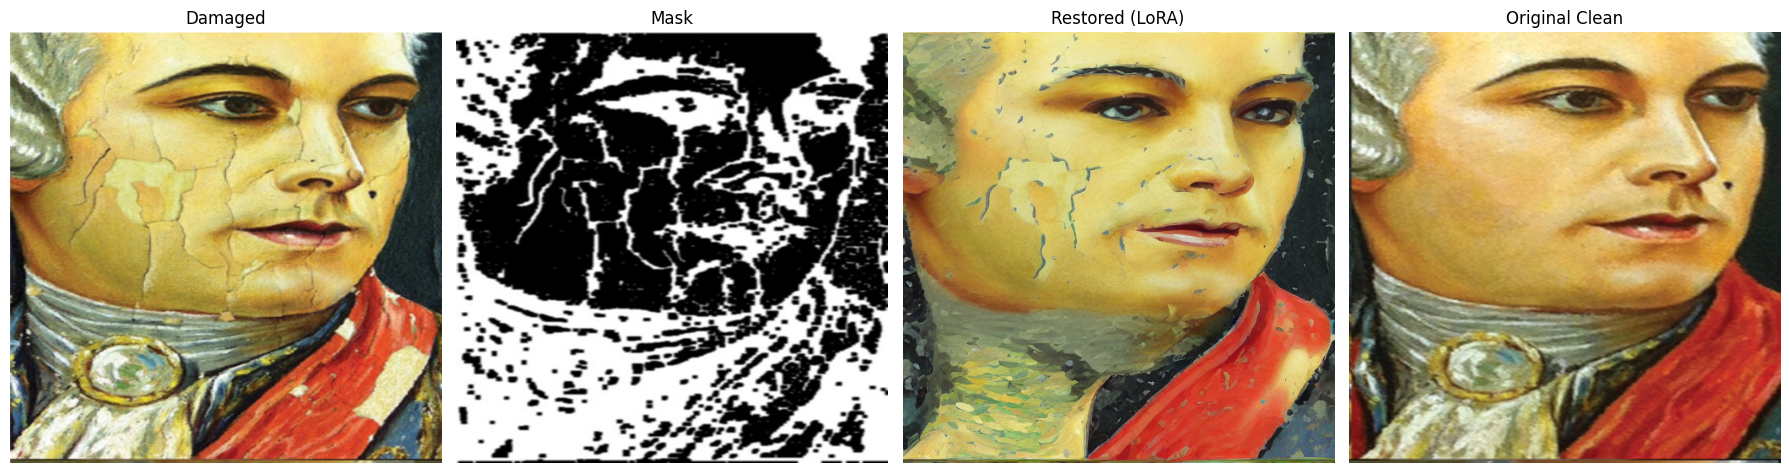

In [ ]:
# VISUAL COMPARISON
# Damaged → Mask → Restored → Clean


import os, random, torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from diffusers import StableDiffusionInpaintPipeline

# SELECT A RANDOM IMAGE

fname = random.choice(os.listdir(DAMAGED_DIR))
print("Testing on:", fname)

damaged_pil = Image.open(os.path.join(DAMAGED_DIR, fname)).convert("RGB").resize((512,512))
mask_pil    = Image.open(os.path.join(MASK_DIR, fname)).convert("L").resize((512,512))
clean_pil   = Image.open(os.path.join(CLEAN_DIR, fname)).convert("RGB").resize((512,512))


# RESTORATION INFERENCE


with torch.no_grad():
    restored_pil = pipe(
        prompt="high quality realistic photo restoration, clean skin, remove cracks and damage",
        negative_prompt="blur, artifacts, distortion, oversharpen",
        image=damaged_pil,
        mask_image=mask_pil,
        num_inference_steps=60,
        guidance_scale=7.5,
        strength=0.85
    ).images[0]


# DISPLAY COMPARISON

plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.imshow(damaged_pil)
plt.title("Damaged")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask_pil, cmap="gray")
plt.title("Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(restored_pil)
plt.title("Restored (LoRA)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(clean_pil)
plt.title("Original Clean")
plt.axis("off")

plt.tight_layout()
plt.show()


Testing on: 006.png


  0%|          | 0/44 [00:00<?, ?it/s]

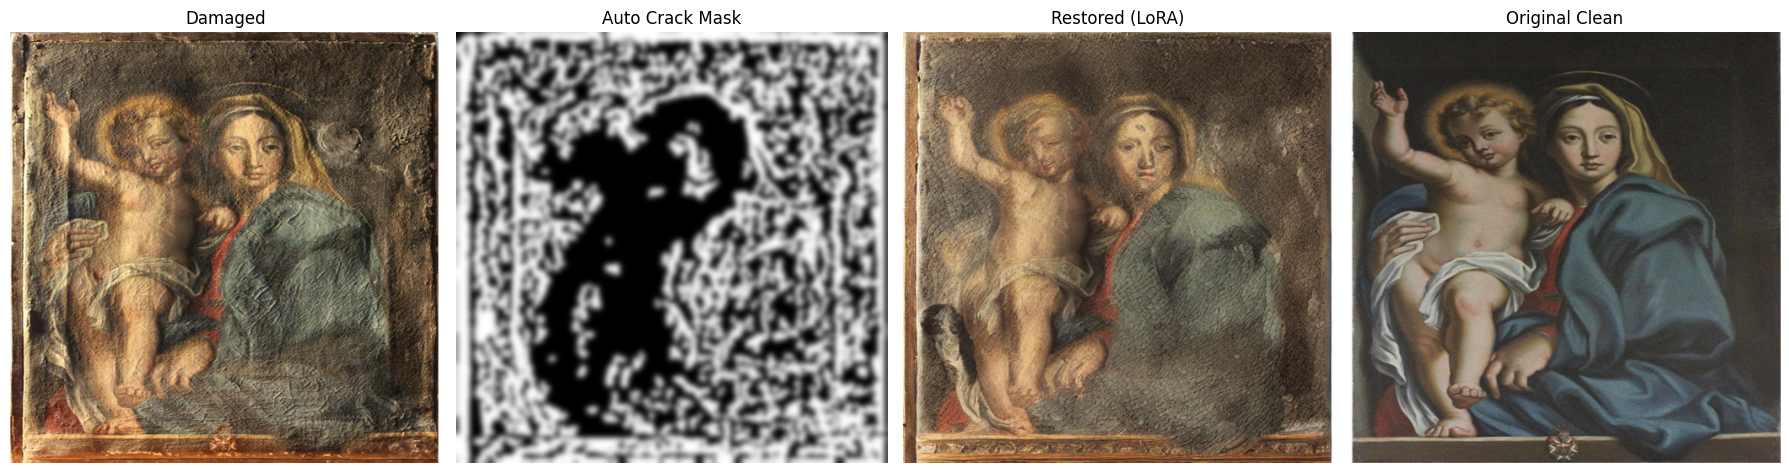

In [ ]:


import os, random, torch, cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


fname = sorted(os.listdir(DAMAGED_DIR))[5]
print("Testing on:", fname)

damaged_pil = Image.open(os.path.join(DAMAGED_DIR, fname)).convert("RGB").resize((512,512))
clean_pil   = Image.open(os.path.join(CLEAN_DIR, fname)).convert("RGB").resize((512,512))


dam_np = np.array(damaged_pil)

# 1. Grayscale
gray = cv2.cvtColor(dam_np, cv2.COLOR_RGB2GRAY)

# 2. Black-hat to extract dark cracks
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 25))
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

# 3. Contrast stretch (THIS WAS MISSING)
blackhat = cv2.normalize(blackhat, None, 0, 255, cv2.NORM_MINMAX)

# 4. Adaptive threshold (instead of fixed Canny)
mask_bin = cv2.adaptiveThreshold(
    blackhat,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY,
    31,
    3
)

# 5. Clean salt noise
kernel = np.ones((3,3), np.uint8)
mask_bin = cv2.morphologyEx(mask_bin, cv2.MORPH_OPEN, kernel, iterations=1)

# 6. Strengthen real cracks
mask_bin = cv2.dilate(mask_bin, kernel, iterations=1)

# 7. AREA FILTER (RELAXED — THIS IS THE FIX)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_bin, connectivity=8)

filtered = np.zeros_like(mask_bin)
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    if 40 < area < 25000:
        filtered[labels == i] = 255

# 8. Museum-grade feathering
mask_soft = cv2.GaussianBlur(filtered, (21,21), 0)

mask_pil = Image.fromarray(mask_soft).convert("L")


# LoRA RESTORATION


with torch.no_grad():
    restored_pil = pipe(
        prompt="museum-quality oil painting restoration, remove only cracks and paint damage, preserve original face and lighting",
        negative_prompt="scratches, cracks, texture artifacts, repaint, blur, identity change",
        image=damaged_pil,
        mask_image=mask_pil,
        num_inference_steps=80,
        guidance_scale=4.8,
        strength = 0.55
    ).images[0]


plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.imshow(damaged_pil)
plt.title("Damaged")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask_pil, cmap="gray")
plt.title("Auto Crack Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(restored_pil)
plt.title("Restored (LoRA)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(clean_pil)
plt.title("Original Clean")
plt.axis("off")

plt.tight_layout()
plt.show()


Mask intensity: 23.714183807373047


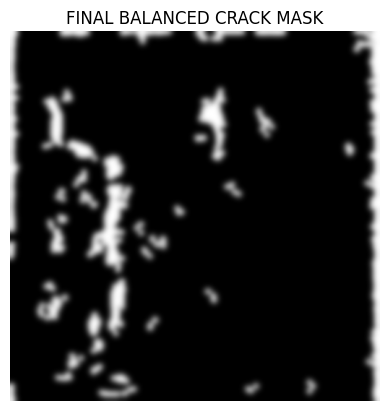

  0%|          | 0/65 [00:00<?, ?it/s]

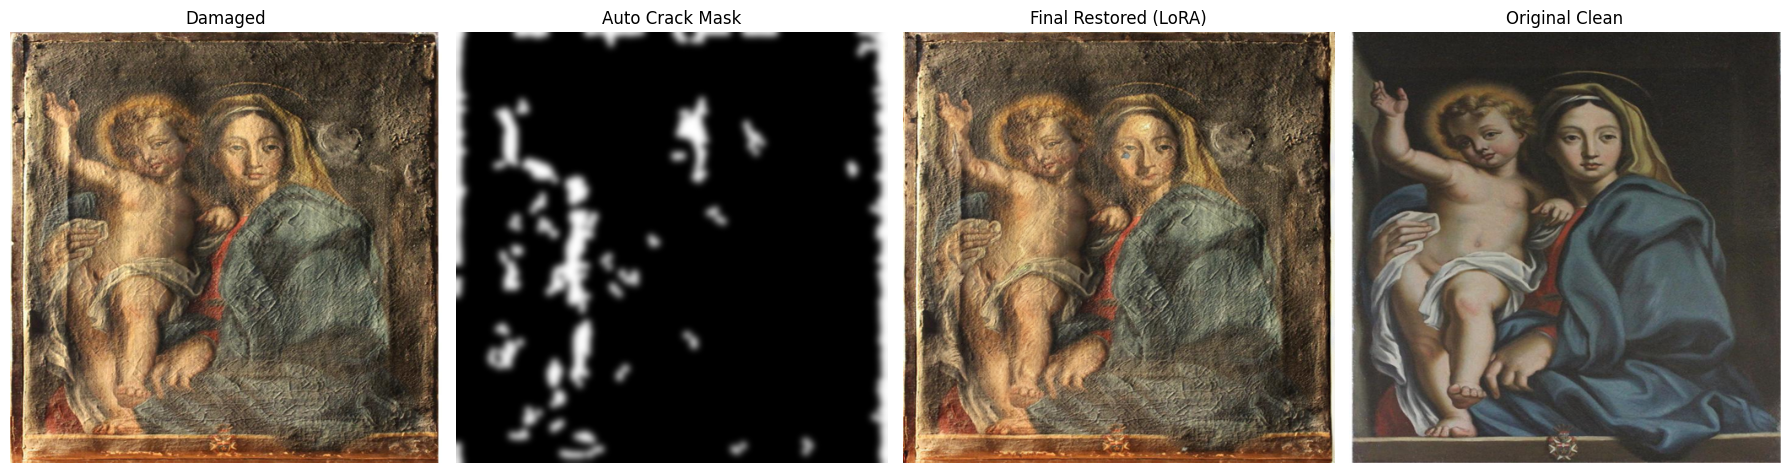

In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch

dam_np = np.array(damaged_pil)

lab = cv2.cvtColor(dam_np, cv2.COLOR_RGB2LAB)
l, a, b = cv2.split(lab)

hp = cv2.Laplacian(l, cv2.CV_8U, ksize=3)
hp = cv2.normalize(hp, None, 0, 255, cv2.NORM_MINMAX)

_, crack_bin = cv2.threshold(hp, 8, 255, cv2.THRESH_BINARY)

_, paint_loss = cv2.threshold(l, 200, 255, cv2.THRESH_BINARY)

raw_mask = cv2.bitwise_or(crack_bin, paint_loss)
kernel = np.ones((3,3), np.uint8)
raw_mask = cv2.morphologyEx(raw_mask, cv2.MORPH_OPEN, kernel)
raw_mask = cv2.dilate(raw_mask, kernel, iterations=2)
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(raw_mask, connectivity=8)

filtered = np.zeros_like(raw_mask)
for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]


    if 120 < area < 6000:
        filtered[labels == i] = 255


mask_soft = cv2.GaussianBlur(filtered, (25,25), 0)
mask_pil = Image.fromarray(mask_soft).convert("L")


print("Mask intensity:", np.mean(np.array(mask_pil)))

plt.imshow(mask_pil, cmap="gray")
plt.title("FINAL BALANCED CRACK MASK")
plt.axis("off")
plt.show()


with torch.no_grad():
    restored = pipe(
        prompt="museum-quality realistic oil painting restoration, reconstruct missing paint, remove cracks only, preserve original faces and lighting",
        negative_prompt="blur, distortion, repainting, wax texture, identity change",
        image=damaged_pil,
        mask_image=mask_pil,
        num_inference_steps=80,
        guidance_scale=6.5,
        strength=0.82
    ).images[0]


rest_np  = np.array(restored).astype(np.float32)
orig_np  = np.array(damaged_pil).astype(np.float32)
mask_np  = np.array(mask_pil).astype(np.float32) / 255.0


mask_np = np.clip(mask_np * 1.35, 0, 1)

final = rest_np * mask_np[..., None] + orig_np * (1 - mask_np[..., None])
final = np.clip(final, 0, 255).astype(np.uint8)
final_pil = Image.fromarray(final)

plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
plt.imshow(damaged_pil)
plt.title("Damaged")
plt.axis("off")

plt.subplot(1,4,2)
plt.imshow(mask_pil, cmap="gray")
plt.title("Auto Crack Mask")
plt.axis("off")

plt.subplot(1,4,3)
plt.imshow(final_pil)
plt.title("Final Restored (LoRA)")
plt.axis("off")

plt.subplot(1,4,4)
plt.imshow(clean_pil)
plt.title("Original Clean")
plt.axis("off")

plt.tight_layout()
plt.show()


Metrics Calculation

In [ ]:
!pip install -q scikit-image


In [ ]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np

def compute_metrics(clean_pil, restored_pil):
    clean = np.array(clean_pil).astype(np.float32)
    restored = np.array(restored_pil).astype(np.float32)

    psnr_val = psnr(clean, restored, data_range=255)

    ssim_val = ssim(
        clean,
        restored,
        data_range=255,
        channel_axis=2
    )

    return psnr_val, ssim_val


In [ ]:
import random, cv2, torch, numpy as np
from tqdm import tqdm
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

NUM_SAMPLES = 50

psnr_damaged_list  = []
ssim_damaged_list  = []
psnr_restored_list = []
ssim_restored_list = []

pipe.unet.eval()
pipe.vae.eval()
pipe.text_encoder.eval()

def tensor_to_pil(t):
    if t.min() < 0:
        t = (t + 1) / 2
    t = t.squeeze().permute(1,2,0).cpu().numpy()
    t = (t * 255).clip(0,255).astype(np.uint8)
    return Image.fromarray(t)

def compute_metrics(gt_img, pred_img):
    gt   = np.array(gt_img).astype(np.float32)
    pred = np.array(pred_img).astype(np.float32)

    psnr_val = psnr(gt, pred, data_range=255)
    ssim_val = ssim(gt, pred, data_range=255, channel_axis=2)

    return psnr_val, ssim_val

for _ in tqdm(range(NUM_SAMPLES)):

    idx = random.randint(0, len(dataset)-1)
    sample = dataset[idx]

    clean_pil   = tensor_to_pil(sample["clean"])
    damaged_pil = tensor_to_pil(sample["damaged"])

    mask_np = sample["mask"].squeeze().cpu().numpy()
    mask_np = (mask_np * 255).astype(np.uint8)
    kernel = np.ones((5,5), np.uint8)
    mask_np = cv2.erode(mask_np, kernel, iterations=1)
    mask_np = cv2.GaussianBlur(mask_np, (11,11), 0)

    mask_pil = Image.fromarray(mask_np).convert("L")
    with torch.no_grad():
        restored = pipe(
            prompt="photorealistic face restoration, preserve identity, natural skin texture",
            negative_prompt="scratches, streaks, artifacts, repainting",
            image=damaged_pil,
            mask_image=mask_pil,
            num_inference_steps=40,
            guidance_scale=3.5,
            strength=0.6
        ).images[0]

    # METRICS
    p_d, s_d = compute_metrics(clean_pil, damaged_pil)
    p_r, s_r = compute_metrics(clean_pil, restored)

    psnr_damaged_list.append(p_d)
    ssim_damaged_list.append(s_d)
    psnr_restored_list.append(p_r)
    ssim_restored_list.append(s_r)

# FINAL RESULTS
print("\nFINAL FAIR EVALUATION RESULTS \n")

print(f"Damaged  → Clean | PSNR: {np.mean(psnr_damaged_list):.2f} | SSIM: {np.mean(ssim_damaged_list):.4f}")
print(f"Restored → Clean | PSNR: {np.mean(psnr_restored_list):.2f} | SSIM: {np.mean(ssim_restored_list):.4f}")

print("\n TRUE IMPROVEMENT:")

print(f"PSNR Gain : {np.mean(psnr_restored_list) - np.mean(psnr_damaged_list):+.2f} dB")
print(f"SSIM Gain : {np.mean(ssim_restored_list) - np.mean(ssim_damaged_list):+.4f}")


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:05<04:49,  5.91s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

  4%|▍         | 2/50 [00:12<05:05,  6.36s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

  6%|▌         | 3/50 [00:18<04:45,  6.07s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

  8%|▊         | 4/50 [00:24<04:45,  6.20s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 10%|█         | 5/50 [00:30<04:38,  6.18s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 12%|█▏        | 6/50 [00:38<04:52,  6.65s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 14%|█▍        | 7/50 [00:43<04:30,  6.30s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 16%|█▌        | 8/50 [00:50<04:31,  6.46s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 18%|█▊        | 9/50 [00:57<04:23,  6.43s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 20%|██        | 10/50 [01:02<04:03,  6.09s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 22%|██▏       | 11/50 [01:07<03:47,  5.84s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 24%|██▍       | 12/50 [01:13<03:35,  5.67s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 26%|██▌       | 13/50 [01:18<03:26,  5.57s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 28%|██▊       | 14/50 [01:23<03:17,  5.49s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 30%|███       | 15/50 [01:29<03:10,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 32%|███▏      | 16/50 [01:34<03:04,  5.43s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 34%|███▍      | 17/50 [01:39<02:58,  5.40s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 36%|███▌      | 18/50 [01:45<02:52,  5.40s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 38%|███▊      | 19/50 [01:50<02:47,  5.39s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 40%|████      | 20/50 [01:55<02:42,  5.40s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 42%|████▏     | 21/50 [02:01<02:36,  5.41s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 44%|████▍     | 22/50 [02:06<02:31,  5.41s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 46%|████▌     | 23/50 [02:12<02:26,  5.41s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 48%|████▊     | 24/50 [02:17<02:20,  5.41s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 50%|█████     | 25/50 [02:23<02:15,  5.43s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 52%|█████▏    | 26/50 [02:28<02:10,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 54%|█████▍    | 27/50 [02:34<02:05,  5.45s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 56%|█████▌    | 28/50 [02:39<02:00,  5.47s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 58%|█████▊    | 29/50 [02:44<01:54,  5.46s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 60%|██████    | 30/50 [02:50<01:49,  5.46s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 62%|██████▏   | 31/50 [02:55<01:43,  5.46s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 64%|██████▍   | 32/50 [03:01<01:38,  5.47s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 66%|██████▌   | 33/50 [03:07<01:33,  5.51s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 68%|██████▊   | 34/50 [03:12<01:27,  5.49s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 70%|███████   | 35/50 [03:17<01:22,  5.49s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 72%|███████▏  | 36/50 [03:23<01:16,  5.48s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 74%|███████▍  | 37/50 [03:28<01:11,  5.49s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 76%|███████▌  | 38/50 [03:34<01:05,  5.49s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 78%|███████▊  | 39/50 [03:39<01:00,  5.50s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 80%|████████  | 40/50 [03:45<00:55,  5.51s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 82%|████████▏ | 41/50 [03:50<00:49,  5.50s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 84%|████████▍ | 42/50 [03:56<00:44,  5.51s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 86%|████████▌ | 43/50 [04:01<00:38,  5.51s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 88%|████████▊ | 44/50 [04:07<00:33,  5.53s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 90%|█████████ | 45/50 [04:13<00:27,  5.53s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 92%|█████████▏| 46/50 [04:18<00:22,  5.54s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 94%|█████████▍| 47/50 [04:24<00:16,  5.57s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 96%|█████████▌| 48/50 [04:29<00:11,  5.55s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

 98%|█████████▊| 49/50 [04:35<00:05,  5.54s/it]

  0%|          | 0/24 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:40<00:00,  5.62s/it]


FINAL FAIR EVALUATION RESULTS 

Damaged  → Clean | PSNR: 13.59 | SSIM: 0.3827
Restored → Clean | PSNR: 13.75 | SSIM: 0.4066

 TRUE IMPROVEMENT:
PSNR Gain : +0.16 dB
SSIM Gain : +0.0240
